### Imports

In [1]:
import pandas as pd
import gzip
import json
import numpy as np

## Download and Convert Dataset

#### Convert dataset from the following format to a CSV
product/productId: B001E4KFG0
review/userId: A3SGXH7AUHU8GW
review/profileName: delmartian
review/helpfulness: 1/1
review/score: 5.0
review/time: 1303862400
review/summary: Good Quality Dog Food
review/text: I have bought several of the Vitality canned dog food products and have
found them all to be of good quality. The product looks more like a stew than a
processed meat and it smells better. My Labrador is finicky and she appreciates this
product better than most.

http://snap.stanford.edu/data/web-FineFoods.html

In [2]:
g = gzip.open('finefoods.txt.gz', 'rb')

df = pd.DataFrame() #dataframe to store reviews

num_rows = 200000   #The file size is very large so limit the number of rows (approximately 1/3 of dataset)
curr_row = 0     #Counter for current row

currRow = {}

for line in g:
    try:
        cleanedLine = line.decode("utf-8").strip().split(': ', 1)
        if(len(cleanedLine) == 1):
            if('review/summary' in currRow and 'review/text' in currRow): #ensure the review is not empty
                df = df.append(currRow, ignore_index=True)
                curr_row += 1
            currRow = {}
        else:
            #add to dataframe
            currRow[cleanedLine[0]] = cleanedLine[1]
    except (UnicodeDecodeError, UnicodeEncodeError):
        pass
    if(num_rows == curr_row):
        break

#Rename headers
df.rename(columns = { 'product/productId': 'productId',
                    'review/helpfulness': 'helpfulness',
                    'review/profileName': 'profileName',
                    'review/score': 'score',
                    'review/summary' : 'summary',
                    'review/text' : 'text',
                    'review/time' : 'time',
                    'review/userId' : 'userId'}, inplace=True)

#Store dataframe as csv
df.to_csv('finefoods.csv')

In [3]:
df.head(2)

,Unnamed: 0,productId,helpfulness,profileName,score,summary,text,time,userId
0,0,B001E4KFG0,1/1,delmartian,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,A3SGXH7AUHU8GW
1,1,B00813GRG4,0/0,dll pa,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000,A1D87F6ZCVE5NK


In [2]:
#Read stored csv, rather than create it again
df = pd.read_csv("finefoods.csv")

## Customer reccomendations using numerical ratings

Source: https://medium.com/@lope.ai/recommendation-systems-from-scratch-in-python-pytholabs-6946491e76c2

In [10]:
ff_sampled = df.sample(20000) #small sample

In [11]:
#create dictionary with new indexes
ff_users = {k: v for v, k in enumerate(list(ff_sampled['userId'].unique()))}
ff_products = {k: v for v, k in enumerate(list(ff_sampled['productId'].unique()))}

In [12]:
ff_num_users = len(ff_users)
ff_num_products = len(ff_products)

#### Split data up into training data and testing data (RMSE)

In [13]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ff_sampled, test_size=.20)

In [21]:
#create a user vs product matrix that contains all ratings values
data_matrix = np.zeros((ff_num_users, ff_num_products))
for index, review in train_data.iterrows():
    #find index equivalent of user and product
    row = ff_users[review['userId']]
    column = ff_products[review['productId']]
    data_matrix[row, column] = review['score']
    
    
#create a user vs product matrix that contains all ratings values
test_data_matrix = np.zeros((ff_num_users, ff_num_products))
for index, review in test_data.iterrows():
    #find index equivalent of user and product
    row = ff_users[review['userId']]
    column = ff_products[review['productId']]
    test_data_matrix[row, column] = review['score']

##### Calculate Similarity

In [22]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

In [23]:
def predict(ratings, similarity, type='reviewer'):
    
    if type == 'reviewer':
        mean_reviewer_rating = ratings.mean(axis=1).reshape(-1,1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        
        ratings_diff = (ratings - mean_reviewer_rating)
        pred = mean_reviewer_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    
    elif type == 'product':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    
    return pred

##### Create item predictions using user and item similarity

In [24]:
user_prediction = predict(data_matrix, user_similarity, type='reviewer') #do it for each chunk
item_prediction = predict(data_matrix, item_similarity, type='product') #do it for each chunk

In [25]:
#Check if the matrix shape matches originial dimensions 
print(user_prediction.shape)
print(item_prediction.shape)
print(ff_num_users)
print(ff_num_products)

(17801, 7764)
(17801, 7764)
17801
7764


#### Evaluvation through RMSE

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [27]:
#user-user predictions
prediction = user_prediction[test_data_matrix.nonzero()].flatten()
ground_truth = test_data_matrix[test_data_matrix.nonzero()].flatten()
print(sqrt(mean_squared_error(prediction, ground_truth)))

4.361098010013852


In [28]:
#item-item predictions
prediction = item_prediction[test_data_matrix.nonzero()].flatten()
ground_truth = test_data_matrix[test_data_matrix.nonzero()].flatten()
print(sqrt(mean_squared_error(prediction, ground_truth)))

4.362368358916537


#### Method for getting item reccomendation for single user

In [29]:
def get_predictions(userId, type='user'):
    #get user index in matrix
    user_idx = ff_users[userId]

    #determine prediction matrix
    prediction_matrix = user_prediction if type == 'user' else item_prediction
    
    #Determine predictions based on user similarity
    pred_dict = {list(ff_sampled['productId'].unique())[v]: k for v, k in enumerate(prediction_matrix[user_idx])}
    
    return pred_dict

In [30]:
user_id = list(ff_users.keys())[0]
pred_dict = get_predictions(user_id, type='user')
    
#Return item's predictions    
item_predictions = sorted(pred_dict, key=pred_dict.get, reverse=True)

print("User {}:".format(user_id))
for i in range(10): 
    print("\t{}. {} {}".format(i+1, item_predictions[i], pred_dict[item_predictions[i]]))

User A2A6SB596ROUZA:
	1. B002QWP89S 0.012528889553904608
	2. B001EO5Q64 0.012023024125573068
	3. B002YJ0118 0.011798195046314627
	4. B0026RQTGE 0.010842671459466144
	5. B003GTR8IO 0.010674049650022324
	6. B0090X8IPM 0.010393013300949243
	7. B005ZBZLT4 0.009887147872617701
	8. B006N3IG4K 0.009830940602803078
	9. B007M83302 0.009830940602803075
	10. B007Y59HVM 0.009549904253729995


In [31]:
user_id = list(ff_users.keys())[0]
pred_dict = get_predictions(user_id, type='item')
    
#Return item's predictions    
item_predictions = sorted(pred_dict, key=pred_dict.get, reverse=True)

print("User {}:".format(user_id))
for i in range(10): 
    print("\t{}. {} {}".format(i+1, item_predictions[i], pred_dict[item_predictions[i]]))

User A2A6SB596ROUZA:
	1. B005J6AGKY 0.0006449486284821693
	2. B001HTG3IQ 0.0006449486284821693
	3. B006ZGE2JS 0.0006449486284821693
	4. B00061KXUA 0.0006449486284821693
	5. B000GFZIN8 0.0006449486284821693
	6. B000LLS410 0.0006449486284821693
	7. B000EEWZC8 0.0006449486284821693
	8. B002CTAVK6 0.0006449333395300329
	9. B000F4ISDW 0.0006446738957901039
	10. B000FPKX5C 0.0006446487466219038


## Determine average sentiment for recommended products 

### Senitment Analysis

In [32]:
import sys
import nltk
import re
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pandas as pd
import string

In [33]:
#Combine emoticons, hashtags, etc. to each term 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

In [34]:
def label_sentiment(row):
    cutoff = .5
    if row['compound'] < -1 * cutoff:
        return "neg"
    elif row['compound'] > cutoff:
        return "pos"
    else:
        return "neu"

In [35]:
sia = SentimentIntensityAnalyzer()

In [36]:
def determine_sentiment(text):
    #Remove stopwords 
    sws = set(stopwords.words('english') + list(string.punctuation) + ['”', '’', '…', '‼', '‼‼', '“', 'i', 'i\'m', 'the', 'they', '-', '<br />'])
    text = ' '.join([i for i in tokens_re.findall(text) if i not in sws])
    
    #perform sentiment analysis
    scores = sia.polarity_scores(text) #Get senitment analysis for the review
    return scores

### Conduct sentiment analysis on the summary of the reviews

In [37]:
def isNaN(string):
    return string != string

In [38]:
summary_labels = []
# summary_pos = []
# summary_neg = []
# summary_neu = []
summary_compound = []
for summary in df['summary']:
    if summary == None or summary == 'nan' or isNaN(summary):
        summary = ''
    scores = determine_sentiment(summary)
    label = label_sentiment(scores) #determine final sentiment
    summary_labels.append(label)
#     summary_pos.append(scores['pos'])
#     summary_neg.append(scores['neg'])
#     summary_neu.append(scores['neu'])
    summary_compound.append(scores['compound'])

# df['summary_pos'] = summary_pos
# df['summary_neg'] = summary_neg
# df['summary_neu'] = summary_neu
df['summary_compound'] = summary_compound
df['summary_label'] = summary_labels

### Conduct sentiment analysis on the full text of the review

In [39]:
text_labels = []
text_pos = []
text_neg = []
text_neu = []
text_compound = []
for full_text in df['text']:
    scores = determine_sentiment(full_text)
    label = label_sentiment(scores) #determine final sentiment
    text_labels.append(label)
    text_pos.append(scores['pos'])
    text_neg.append(scores['neg'])
    text_neu.append(scores['neu'])
    text_compound.append(scores['compound'])

df['text_pos'] = text_pos
df['text_neg'] = text_neg
df['text_neu'] = text_neu
df['text_compound'] = text_compound
df['text_label'] = text_labels

### Determine the average sentiment for each product

In [40]:
ff_product_list = df['productId'].unique()
product_sentiment = pd.DataFrame()
for product in ff_product_list:

    product_reviews = df[df['productId'] == product]
        
    avg_summ_sentiment = product_reviews['summary_compound'].mean()
    avg_text_sentiment = product_reviews['text_compound'].mean()
    
    summ_label = label_sentiment({'compound' : avg_summ_sentiment})
    text_label = label_sentiment({'compound' : avg_text_sentiment})
    
    row = {'productId': product, 
                             'summ_compound': avg_summ_sentiment,
                             'summ_label': summ_label,
                             'text_compound' : avg_text_sentiment,
                             'text_label' : text_label}
    product_sentiment = product_sentiment.append(row , ignore_index=True)
        

In [41]:
product_sentiment.head()

,productId,summ_compound,summ_label,text_compound,text_label
0,B001E4KFG0,0.440400,neu,0.941300,pos
1,B00813GRG4,0.000000,neu,0.076200,neu
2,B000LQOCH0,0.599400,pos,0.807300,pos
3,B000UA0QIQ,0.000000,neu,0.440400,neu
4,B006K2ZZ7K,0.602225,pos,0.934475,pos


## Conduct Topic Modeling to determine topics for each product's reviews

In [42]:
from gensim import corpora, models

In [43]:
def get_products(productId, topics, words):
    product_reviews = df[df['productId'] == productId]
    product_reviews = product_reviews['text']
    
    #Remove stopwords 
    sws = set(stopwords.words('english') + list(string.punctuation) + ['”', '’', '…', '‼', '‼‼', '“', 'i', 'the', 'they', '-', '<br />'])
    sws_removed = []
    for sent in product_reviews:
        sws_removed.append([i for i in tokens_re.findall(sent.lower()) if i not in sws])
        
    #Create dictionary of the words in product reviews
    dictionary = corpora.Dictionary(sws_removed)
    dictionary.filter_extremes(no_below=5, no_above=0.3)  #drop words that show up less than 5 times and in more than 30% of the tweets
    dictionary.compactify()
    
    #create bag of words from dictionary
    corpus = [dictionary.doc2bow(text) for text in sws_removed]
    
    #create the LDA topic model
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=topics, id2word=dictionary, passes=20)
    
    #print topics for reviews
    for i, topic in ldamodel.print_topics(num_topics=3, num_words=5):
        print("\tTopic:{}  {}".format(i, topic))

In [44]:
topics = 2
words = 5
get_products("B0026RQTGE", topics, words)

	Topic:0  0.022*"price" + 0.021*"product" + 0.019*"amazon" + 0.014*"great" + 0.013*"box"
	Topic:1  0.024*"one" + 0.021*"loves" + 0.018*"breath" + 0.016*"treat" + 0.016*"love"


## Combine all three evaluvations for reccomendation system (Final Algorithm)

In [45]:
#determine user
userId = list(ff_users.keys())[0]

In [65]:
def get_user_reccomendations(userId, top_num, pred_type):
    #Get user based predicitons for user (user-user similarity)
    item_predictions = get_predictions(userId, pred_type)
    
    #Return item's predictions    
    prediction_keys = sorted(item_predictions, key=item_predictions.get, reverse=True)
    
    #Demote all products that have a negative sentiment below products with positive and negative sentiment reviews
    good_product = product_sentiment[product_sentiment['text_label'] == 'pos']
    good_product.append(product_sentiment[product_sentiment['text_label'] == 'neu'])
    neg_products = [item for item in prediction_keys if item in good_product['productId']]
    
    prediction_keys = [item for item in prediction_keys if item not in neg_products]
    #Add negative products to the end
    for i in range(len(neg_products)):
        prediction_keys.append(neg_products[i])
    
    #Print top products with sentiment and topic
    print("User {}:\nTop {} reccomendations".format(userId, top_num))
    for i in range(top_num):
        curr_item = prediction_keys[i]
        full_item = product_sentiment[product_sentiment['productId'] == curr_item]
        print("  {}. {} similarity:{:.6f} {}:{:.6f}".format(i+1, curr_item, item_predictions[curr_item], full_item['text_label'].values[0], full_item['text_compound'].values[0]))
        get_products(curr_item, 3, 4)
        

In [66]:
get_user_reccomendations(userId, 4, 'user')

User A2A6SB596ROUZA:
Top 4 reccomendations
  1. B002QWP89S similarity:0.012529 pos:0.694115
	Topic:0  0.025*"price" + 0.025*"product" + 0.024*"great" + 0.021*"amazon" + 0.018*"love"
	Topic:1  0.026*"one" + 0.025*"greenie" + 0.019*"day" + 0.016*"treat" + 0.015*"loves"
	Topic:2  0.016*"get" + 0.014*"one" + 0.014*"breath" + 0.014*"love" + 0.013*"treats"
  2. B001EO5Q64 similarity:0.012023 pos:0.814885
	Topic:0  0.025*"hair" + 0.024*"skin" + 0.013*"used" + 0.013*"also" + 0.011*"good"
	Topic:1  0.019*"organic" + 0.019*"nutiva" + 0.015*"good" + 0.014*"like" + 0.014*"virgin"
	Topic:2  0.020*"like" + 0.016*"using" + 0.012*"would" + 0.011*"really" + 0.010*"butter"
  3. B002YJ0118 similarity:0.011798 pos:0.753839
	Topic:0  0.026*"oil" + 0.022*"popper" + 0.020*"oz" + 0.018*"salt" + 0.011*"use"
	Topic:1  0.024*"best" + 0.020*"taste" + 0.019*"product" + 0.019*"popper" + 0.017*"northern"
	Topic:2  0.023*"movie" + 0.022*"salt" + 0.017*"theater" + 0.015*"taste" + 0.014*"use"
  4. B0026RQTGE similarity

Distribution of Positivie Sentiment Scores of Product Reviews:


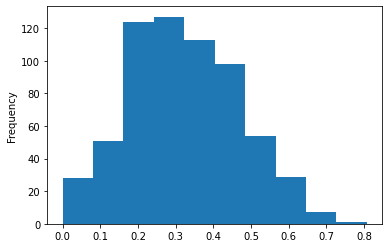

In [67]:
        #print plots of positive and compound values  
        print("Distribution of Positivie Sentiment Scores of Product Reviews:")
        df[df['productId'] == "B002QWP89S"]['text_pos'].plot.hist()